# Выделение групп пользователей на основе поведения

Цель - определить группы пользователей, у которых выше удержание в мобильном приложении "Ненужные вещи" и выше конверсия в целевое ("contacts_show") действие.

Задачи (подробнее описаны на этапе декомпозиция):
- выгрузка данных;
- предобработка данных;
- анализ общего поведения пользователей;
- сегментирование пользователей;
- проверка статистических гипотез;
- подготовка презентации по результатам анализа.

Для анализа предоставлен датасет с двумя таблицами, которые содержат данные о идентификаторах пользователей, источниках привлечения пользователей, действия, совершенного в приложении, времени, когда действие совершено.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import math as mth

## Выгрузка данных

In [2]:
mob_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv')

In [3]:
display(mob_sources.head(10))
print(mob_sources.info())

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google
5,17f6b2db-2964-4d11-89d8-7e38d2cb4750,yandex
6,62aa104f-592d-4ccb-8226-2ba0e719ded5,yandex
7,57321726-5d66-4d51-84f4-c797c35dcf2b,google
8,c2cf55c0-95f7-4269-896c-931d14deaab5,google
9,48e614d6-fe03-40f7-bf9e-4c4f61c19f64,yandex


<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 4293 entries, 0 to 4292
,Data columns (total 2 columns):
, #   Column  Non-Null Count  Dtype 
,---  ------  --------------  ----- 
, 0   userId  4293 non-null   object
, 1   source  4293 non-null   object
,dtypes: object(2)
,memory usage: 67.2+ KB
,None


В таблице с источником два столбца, 4293 строки. Пропусков нет.

In [4]:
mob_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

display(mob_dataset.head(10))
print(mob_dataset.info())

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
5,2019-10-07 00:01:19.993624,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
6,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
7,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
8,2019-10-07 00:01:49.732803,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
9,2019-10-07 00:01:54.958298,advert_open,020292ab-89bc-4156-9acf-68bc2783f894


<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 74197 entries, 0 to 74196
,Data columns (total 3 columns):
, #   Column      Non-Null Count  Dtype 
,---  ------      --------------  ----- 
, 0   event.time  74197 non-null  object
, 1   event.name  74197 non-null  object
, 2   user.id     74197 non-null  object
,dtypes: object(3)
,memory usage: 1.7+ MB
,None


В таблице с событиями три столбца, 74197 строки. Пропусков данных нет.

## Предобработка данных

In [5]:
# Изменение типа данных для столбца с датой и временем
mob_dataset['event.time'] = pd.to_datetime(mob_dataset['event.time'])

In [6]:
# Изменение названий столбцов для удобства
mob_dataset = mob_dataset.rename(columns={'event.time':'event_time', 'event.name':'event_name', 'user.id':'user_id'})
mob_sources = mob_sources.rename(columns={'userId':'user_id'})

In [7]:
mob_sources.duplicated().sum()

0

In [8]:
mob_dataset.duplicated().sum()

0

In [9]:
mob_dataset.loc[mob_dataset['event_name']=='show_contacts', 'event_name'] = 'contacts_show' # замена неявных дубликатов,
                                                                                            # указанных в задании

В таблицах не встречены явные дубликаты.

## Анализ общего поведения данных

### Расчет Retention Rate

In [10]:
dt = mob_dataset.sort_values(['user_id', 'event_time'])

In [11]:
dt['event_time'] = pd.to_datetime(dt['event_time'])

Окончанием сессии принимается действие пользователя, когда до следующего действия проходит более 30 минут. С одной стороны меньшее время указывает на более частое вовлечение пользователя в приложение, это характерно обычно для приложений социальных сетей или мессенджеров. С другой стороны - большее время характерно для других типов приложений (онлайн банк, услуги доставки еды и т.д.). За время 30 минут, если это было случайное прерывание сессии можно успеть ответить на телефонный звонок, сообщение и т.п. А уже свыше 30 минут может означать, что пользователь уже перестроил свои мысли в другом направлении, вряд ли он вернется к тому же товару спустя такое время.

In [12]:
# деление событий по сессиям, принято, что между сессиями более 30 минут 
diff_etime = dt.groupby('user_id')['event_time'].diff()
new_session = (diff_etime.isnull()) | (diff_etime > pd.Timedelta('30Min'))
dt['session_id'] = dt.loc[new_session, ['user_id', 'event_time']].groupby('user_id').rank(method='first').astype(int)
dt['session_id'] = dt['session_id'].fillna(method='ffill').astype(int)

In [13]:
# определение функции для формирования таблицы с показателями удержания до 7 дня
def retention_calc(data):
    dt1 = data.sort_values('event_time')
    dt1.event_time = dt1.event_time.dt.date
    
    df_cohort = dt1.groupby('user_id')['event_time'].min().reset_index().rename(columns={'event_time':'cohort_date'})

    df = dt1.merge(df_cohort, on='user_id')
    
    df["days_diff"] = (df["event_time"] - df["cohort_date"]).dt.days

    cohort_sizes = df_cohort.groupby("cohort_date")["user_id"].nunique().reset_index()
    cohort_sizes.columns = ["cohort_date", "cohort_size"]

    retention_data = df.groupby(["cohort_date", "days_diff"])["user_id"].nunique().reset_index()
    retention_data = retention_data.pivot_table(
    index="cohort_date",
    columns="days_diff",
    values="user_id",
    fill_value=0
    )

    retention_data = retention_data.merge(cohort_sizes, on="cohort_date")

    for day in range(1,8):
        if day in retention_data.columns:
            retention_data[f"день_{day}"] = (retention_data[day] / retention_data["cohort_size"]) * 100
        
    retention_rate = retention_data[["cohort_date", "cohort_size"] + [f"день_{day}" for day in range(1,8) if f"день_{day}" in retention_data.columns]]
    
    return retention_rate

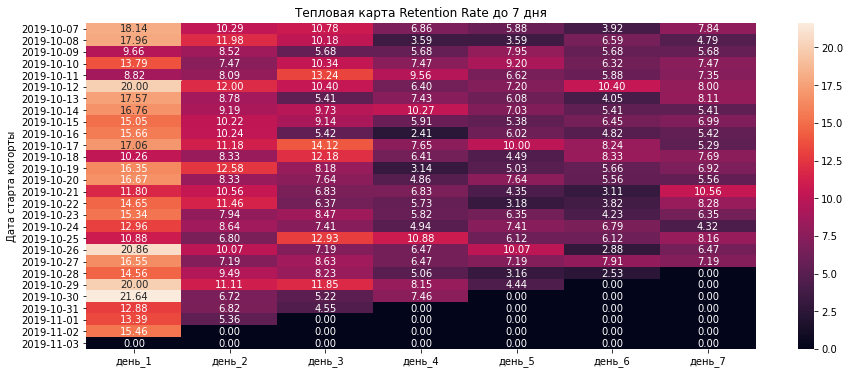

In [14]:
retention_rate1 = retention_calc(mob_dataset)

plt.figure(figsize = (15, 6))
sns.heatmap(
    retention_rate1.drop(columns = ['cohort_size']).set_index(['cohort_date']),
    annot = True, 
    fmt = '.2f',
) 
plt.title('Тепловая карта Retention Rate до 7 дня')
plt.ylabel('Дата старта когорты')
plt.show()

По тепловой карте заметно, что в данных представлена информация о юзерах, начинавших использовать приложение с 7 октября по 3 ноября 2019 года.

К седьмому дню удержание в основном превышает 5%, самое низкое для когорты, начавшейся 24 октября (4.32%), самое высокое - для когорты 21 октября (10.56%).

### Определние времени, проведенного в приложении пользователем

In [15]:
# определение функции, делящей на группы по уровню продолжительности использования приложения
def time_group(x):
    if x < 0.25:
        return 'низкая'
    elif x < 1:
        return 'средняя'
    else:
        return 'высокая'

In [16]:
session_start = dt.groupby(['user_id', 'session_id'])['event_time'].min().reset_index().rename(columns={'event_time':'start_time'})
session_end = dt.groupby(['user_id', 'session_id'])['event_time'].max().reset_index().rename(columns={'event_time':'end_time'})
sessions = session_start.merge(session_end, on=['user_id', 'session_id'])
sessions['session_duration'] = (sessions['end_time'] - sessions['start_time'])
full_time = sessions.groupby(['user_id'])['session_duration'].sum().reset_index()
full_time['session_duration'] = round(full_time['session_duration'].dt.total_seconds() / 3600, 2)

full_time['time_group'] = full_time.session_duration.apply(time_group)

full_time

,user_id,session_duration,time_group
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0.77,средняя
1,00157779-810c-4498-9e05-a1e9e3cedf93,3.27,высокая
2,00463033-5717-4bf1-91b4-09183923b9df,0.41,средняя
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,1.85,высокая
4,00551e79-152e-4441-9cf7-565d7eb04090,0.16,низкая
...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,0.82,средняя
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,0.01,низкая
4290,ffcf50d9-293c-4254-8243-4890b030b238,0.02,низкая
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,0.65,средняя


In [17]:
display(full_time.groupby(['time_group'])['user_id'].count().reset_index())

,time_group,user_id
0,высокая,507
1,низкая,2117
2,средняя,1669


Принимая, что низкая продолжительность использования приложения менее 15 минут, средняя - менее 60 минут, а высокая - не менее 60 минут, получились следующие группы:
- с низкой продолжительностью 2117 пользователей;
- со средней продолжительностью 1669 пользователей;
- с высокой продолжительностью 507 пользователей.

### Определение частоты действий пользователей

In [18]:
# определение функции, делящей на группы по частоте совершаемых событий
def ev_p_d(x):
    if x < 5:
        return 'низкая'
    elif x < 10:
        return 'средняя'
    else:
        return 'высокая'

In [19]:
event_freak = dt.groupby(['user_id']).agg(event_cnt=('event_name','count'), first_event=('event_time','min'),
                                                   last_event=('event_time','max')).reset_index()
event_freak['full_time'] = (event_freak.last_event - event_freak.first_event).dt.days + 1

event_freak['events_per_day'] = round(event_freak.event_cnt / event_freak.full_time, 1)

event_freak['events_per_day_group'] = event_freak['events_per_day'].apply(ev_p_d)

event_freak

,user_id,event_cnt,first_event,last_event,full_time,events_per_day,events_per_day_group
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35,2019-10-07 13:39:45.989359,2019-10-22 11:30:52.807203,15,2.3,низкая
1,00157779-810c-4498-9e05-a1e9e3cedf93,71,2019-10-19 21:34:33.849769,2019-11-03 17:12:09.708771,15,4.7,низкая
2,00463033-5717-4bf1-91b4-09183923b9df,10,2019-11-01 13:54:35.385028,2019-11-01 14:19:17.860053,1,10.0,высокая
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32,2019-10-18 22:14:05.555052,2019-10-31 21:42:15.606558,13,2.5,низкая
4,00551e79-152e-4441-9cf7-565d7eb04090,8,2019-10-25 16:44:41.263364,2019-10-29 02:17:12.342406,4,2.0,низкая
...,...,...,...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,17,2019-10-13 16:11:27.414960,2019-10-26 19:53:51.993545,14,1.2,низкая
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,7,2019-10-07 20:32:49.997044,2019-10-07 20:33:42.135500,1,7.0,средняя
4290,ffcf50d9-293c-4254-8243-4890b030b238,2,2019-10-23 11:51:35.199237,2019-10-23 11:52:55.577369,1,2.0,низкая
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,13,2019-10-21 16:39:33.867145,2019-10-28 07:17:52.646652,7,1.9,низкая


In [20]:
display(event_freak.groupby(['events_per_day_group'])['user_id'].count().reset_index())

,events_per_day_group,user_id
0,высокая,1302
1,низкая,1558
2,средняя,1433


Принимая, что низкая частота действий менее 5 действий, средняя - менее 10 действий, а высокая - не менее 10 действий, получились следующие группы:
- с низкой частотой 1558 пользователей;
- со средней частотой 1433 пользователя;
- с высокой частотой 1302 пользователя.

### Определение конверсии в целевое действие (просмотр контактов)

In [21]:
# определение функции, рассчитывающей конверсию в целевое событие по источникам привлечения пользователей,
# а так же общую конверсию
def conv_final_event(data):

    user_events = data.groupby(['user_id'])['event_name'].apply(list).reset_index()

    def check_conv(x):
        return 'contacts_show' in x

    user_events['user_conversion'] = user_events['event_name'].apply(check_conv)

    user_events = user_events.merge(mob_sources[['user_id','source']], on='user_id', how='left')

    conv_by_source = user_events.groupby('source')['user_conversion'].agg(
        total_users='count',
        converted_users='sum',
        conversion_rate='mean'
    ).reset_index()

    return conv_by_source, user_events['user_conversion'].mean()

In [22]:
display(conv_final_event(dt)[0])
print('Полная конверсия -', round(conv_final_event(dt)[1],2))

,source,total_users,converted_users,conversion_rate
0,google,1129,275,0.243578
1,other,1230,228,0.185366
2,yandex,1934,478,0.247156


Полная конверсия - 0.23


Наиболее конвертируемые пользователи привлечены из источника "Yandex", конверсия около 25%. Конверсия пользователей из "Google" чуть меньше - около 24%. Из других источников пользователи конвертируются хуже - около 19%.

## Сегментирование пользователей

Проверка будет происходить по разделению пользователей по частоте действий в приложении. Как указывалось выше, выделены три группы: с низкой частотой (менее 5 действий в день), со средней частотой (менее 10 действий в день) и с высокой частотой (не менее 10 действий в день).

Частота совершения действий - хороший критерий для деления пользователей на группы, потому что:
- Частота отражает вовлечённость. В теории пользователи с высокой частотой действий обычно более лояльны и склонны к конверсии;
- Частота может быть связана с бизнес-показателями (конверсией в покупку);
- Пользователи, которые часто производят действия в теории должны быть вовлечены в процесс и открывать приложение (удерживаться) лучше, чем те, кто редко производит действия.

### Определение лучших по Retention Rate

In [23]:
low_events = event_freak.loc[event_freak['events_per_day_group']=='низкая', ['user_id',]].reset_index()#.merge(mob_dataset[''])
middle_events = event_freak.loc[event_freak['events_per_day_group']=='средняя', ['user_id',]].reset_index()
high_events = event_freak.loc[event_freak['events_per_day_group']=='высокая', ['user_id',]].reset_index()

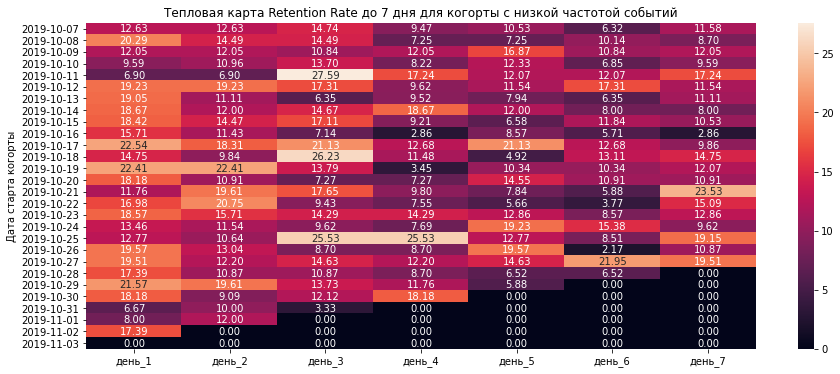

In [24]:
low_events = low_events.merge(mob_dataset[['user_id','event_time','event_name']], on=['user_id'], how='left')

retention_rate_low = retention_calc(low_events)

plt.figure(figsize = (15, 6))
sns.heatmap(
    retention_rate_low.drop(columns = ['cohort_size']).set_index(['cohort_date']),
    annot = True, 
    fmt = '.2f',
) 
plt.title('Тепловая карта Retention Rate до 7 дня для когорты с низкой частотой событий')
plt.ylabel('Дата старта когорты')
plt.show()

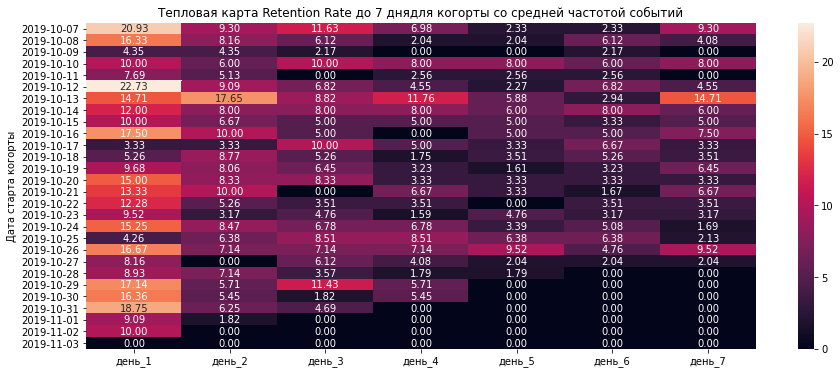

In [25]:
middle_events = middle_events.merge(mob_dataset[['user_id','event_time','event_name']], on=['user_id'], how='left')

retention_rate_middle = retention_calc(middle_events)

plt.figure(figsize = (15, 6))
sns.heatmap(
    retention_rate_middle.drop(columns = ['cohort_size']).set_index(['cohort_date']),
    annot = True, 
    fmt = '.2f',
) 
plt.title('Тепловая карта Retention Rate до 7 днядля когорты со средней частотой событий')
plt.ylabel('Дата старта когорты')
plt.show()

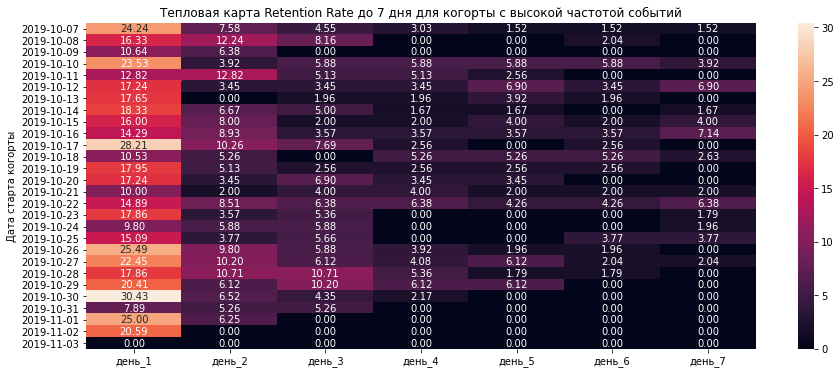

In [26]:
high_events = high_events.merge(mob_dataset[['user_id','event_time','event_name']], on=['user_id'], how='left')

retention_rate_high = retention_calc(high_events)

plt.figure(figsize = (15, 6))
sns.heatmap(
    retention_rate_high.drop(columns = ['cohort_size']).set_index(['cohort_date']),
    annot = True, 
    fmt = '.2f',
) 
plt.title('Тепловая карта Retention Rate до 7 дня для когорты с высокой частотой событий')
plt.ylabel('Дата старта когорты')
plt.show()

Сравнивая тепловые карты для разных групп, можно прийти к выводу, что наиболее удерживаемые пользователи с низкой частотой действия, а наименее удерживаемые - с высокой. То есть чем меньше в день пользователь совершает действий в приложении, тем чаще в последующие дни он обращается к приложению.

Это не совпадает с предполагаемыми выводами. Нужны будут дополнительные исследования.

### Определение лучших по конверсии в целевое действие

In [34]:
display(conv_final_event(high_events)[0])
print('Полная конверсия когорты с высокой частотой событий -', round(conv_final_event(high_events)[1],2))

,source,total_users,converted_users,conversion_rate
0,google,369,100,0.271003
1,other,346,66,0.190751
2,yandex,587,171,0.291312


Полная конверсия когорты с высокой частотой событий - 0.26


In [35]:
display(conv_final_event(low_events)[0])
print('Полная конверсия когорты с низкой частотой событий -', round(conv_final_event(low_events)[1],2))

,source,total_users,converted_users,conversion_rate
0,google,396,101,0.255051
1,other,462,89,0.192641
2,yandex,700,171,0.244286


Полная конверсия когорты с низкой частотой событий - 0.23


In [36]:
display(conv_final_event(middle_events)[0])
print('Полная конверсия когорты со средней частотой событий -', round(conv_final_event(middle_events)[1],2))

,source,total_users,converted_users,conversion_rate
0,google,364,74,0.203297
1,other,422,73,0.172986
2,yandex,647,136,0.210201


Полная конверсия когорты со средней частотой событий - 0.2


Наибольшая конверсия в целевое действие наблюдается для пользователей, которые совершают наибольшее количество действий в день - около 26%. Наименьшая конверсия - для пользователей с со средней частотой действий (от 5 до 10 в день) - около 20%.

Эти результаты совпадают с предполагаемыми выводами.

## Проверка статистических гипотез

### Некоторые пользователи установили приложение по ссылке из yandex, другие — из google . Гипотеза: две эти группы демонстрируют разную конверсию в просмотры контактов

Нулевая гипотеза: группы пользователей, привлеченных из Google и Yandex, демонстрируют одинаковую конверсию в просмотры контактов. Альтернативная гипотеза: пользователи, привлеченные из разных источников, демонстрируют различную конверсию в просмотры контактов.

In [30]:
hip_1 = conv_final_event(dt)[0]
hip_1 = hip_1[hip_1['source'].isin(['google','yandex'])]

n_google = hip_1.loc[hip_1['source']=='google', ['total_users']].values[0]
conv_google = hip_1.loc[hip_1['source']=='google', ['converted_users']].values[0]
p_google = hip_1.loc[hip_1['source']=='google', ['conversion_rate']].values[0]

n_yandex = hip_1.loc[hip_1['source']=='yandex', ['total_users']].values[0]
conv_yandex = hip_1.loc[hip_1['source']=='yandex', ['converted_users']].values[0]
p_yandex = hip_1.loc[hip_1['source']=='yandex', ['conversion_rate']].values[0]

p_combined = (conv_google + conv_yandex)/(n_google+n_yandex)

z_value = (p_google-p_yandex)/mth.sqrt(p_combined * (1-p_combined) * (1/n_google + 1/n_yandex))

distr = st.norm(0,1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value:', round(*p_value, 3))

if p_value < 0.05:
    print('Группы из разных источников демонстрируют разную конверсию')
else:
    print('Группы из разных источников демонстрируют схожую конверсию')

p-value: 0.824
,Группы из разных источников демонстрируют схожую конверсию


### H₀: Величина коверсии в целевое действие не зависит от времени сессии (утро/вечер). H₁:  Величина коверсии в целевое действие выше в вечерние сессии, чем в утренние

За утро примем интервал суток от 4:00 до 10:00, а вечер - с 18:00 до 24:00.

In [31]:
mor_ev_ses = dt.groupby(['user_id','session_id'])['event_time'].agg(start_ses='min', finish_ses='max',).reset_index()

morning_sessions = mor_ev_ses[(mor_ev_ses['start_ses'].dt.hour >= 4) & (mor_ev_ses['finish_ses'].dt.hour < 10)].merge(dt[['user_id','session_id','event_name']],on=['user_id','session_id'],how='left')

evening_sessions = mor_ev_ses[(mor_ev_ses['start_ses'].dt.hour >= 18)].merge(dt[['user_id','session_id','event_name']],on=['user_id','session_id'],how='left')

In [32]:
conv_morning = conv_final_event(morning_sessions)[0]
conv_evening = conv_final_event(evening_sessions)[0]

In [33]:
n_morning = conv_morning['total_users'].sum()
converted_morning = conv_morning['converted_users'].sum()
p_morning = converted_morning / n_morning

n_evening = conv_evening['total_users'].sum()
converted_evening = conv_evening['converted_users'].sum()
p_evening = converted_evening / n_evening

p_combined = (converted_morning + converted_evening)/(n_morning+n_evening)

z_value = (p_morning-p_evening)/mth.sqrt(p_combined * (1-p_combined) * (1/n_morning + 1/n_evening))

distr = st.norm(0,1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value:', round(p_value, 3))

if p_value < 0.05:
    print('Конверсии утренних и вечерних сессий различаются')
    print('Конверсия утром -', round(p_morning,3), '\nКонверсия вечером -', round(p_evening,3))
else:
    print('Конверсии утренних и вечерних сессий одинаковые')

p-value: 0.033
,Конверсии утренних и вечерних сессий различаются
,Конверсия утром - 0.149 
,Конверсия вечером - 0.184


Конверсия в целевое действие, наблюдаемая в вечерние сессии, выше, чем в утренние сессии. Пользователям по вечерам более интересно искать и интересоваться ненужными вещами.

## Выводы

Были изучены данные о действиях пользователей в мобильном приложении "Ненужные вещи". Определено, что показатель удержания на седьмой день после начала использования почти для всех когорт превышает 5%. Конверсии пользователей в целевое действие (contacts_show), привлеченных из Google и Yandex, примерно равны (24-25%), из других источников ниже (около 19%). 

Исследуя удержание пользователей и конверсию в целевое действие групп, разделенных по частоте совершения событий, констатируем, что удерживается лучше группа, у которой частота совершения действий низкая, а конверсия в целевое действие выше у группы с высокой частотой действия.

Проверяя гипотезу о том, что две группы пользователей, привлеченных из Google и Yandex, демонстрируют разную конверсию в просмотры контактов, приходим к выводу, что гипотеза не верна, конверсии схожи.

Проверяя другую гипотезу, что величина коверсии в целевое действие не зависит от времени сессии (утро/вечер), пришли к выводу, что гипотеза не верна, конверсии разные. Конверсия в вечерние сессии выше, чем в утренние.

Возможные рекомендации:
- обратить внимание на длительность использования мобильного приложения юзерами. С чем может быть связана такая разница между группами пользователей с высокой длительностью и низкой длительностью;
- обратить внимание на группы пользователей, поделенные по частоте совершения действий. С чем может быть связано то, что наиболее активные пользователи удерживаются хуже, чем те, что совершают действия в приложении реже. Либо юзеры быстро находят то, что их интересует, либо их со временем перестает привлекать приложение. Возможно необходимо настроить push-уведомления, чтобы пользователи заходили чаще;
- чтобы улучшить конверсию в утреннее время, нужно внедрить какие-то алгоритмы подбора товаров, которые могут быть интересны людям утром, на что они сами не обращают внимание, это может улучшить показатели конверсии.